**Imports**

In [1]:
import json
import math
from collections import OrderedDict
import torch
from torch import nn, Tensor
from typing import Union, Tuple, List, Iterable, Dict
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import AdamW
from torch.utils.data import DataLoader
from scipy.stats import pearsonr, spearmanr
import numpy as np
import gzip, csv
import pandas as pd
from tqdm.auto import tqdm

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
%pip install transformers
from transformers import AutoTokenizer
# from transformers import AutoModel

### **Custom BERT Implementation**

In [3]:
def gelu(x):
    """Gaussian Error Linear Unit (GELU) activation function."""
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

class Config(object):
    """BERT configuration class."""
    def __init__(self,
                vocab_size,
                hidden_size=768,
                num_hidden_layers=12,
                num_attention_heads=12,
                intermediate_size=3072,
                dropout_prob=0.1,
                max_position_embeddings=512,
                type_vocab_size=2,
                initializer_range=0.02):

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = dropout_prob
        self.attention_probs_dropout_prob = dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range

    @classmethod
    def from_dict(cls, dict_object):
        """Create a Config object from a dictionary."""
        config = Config(vocab_size=None)
        for (key, value) in dict_object.items():
            config.__dict__[key] = value
        return config

class LayerNorm(nn.Module):
      def __init__(self, hidden_size, variance_epsilon=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon

      def forward(self, x):
        # Compute mean and variance
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        # Normalize and scale
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta

class MLP(nn.Module):
      def __init__(self, hidden_size, intermediate_size):
        super(MLP, self).__init__()
        # Expansion layer (linear transformation)
        self.dense_expansion = nn.Linear(hidden_size, intermediate_size)
        # Contraction layer (linear transformation followed by GELU activation)
        self.dense_contraction = nn.Linear(intermediate_size, hidden_size)

      def forward(self, x):
        # Apply expansion and GELU activation
        x = self.dense_expansion(x)
        x = self.dense_contraction(gelu(x))
        return x

class Layer(nn.Module):
    def __init__(self, config):
        """Transformer encoder layer."""
        super(Layer, self).__init__()

        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Linear transformations for query, key, and value
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)
        # Dropout for attention probabilities
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

        # Output linear transformation for attention
        self.attn_out = nn.Linear(config.hidden_size, config.hidden_size)
        # Layer normalization for attention output
        self.ln1 = LayerNorm(config.hidden_size)
        # Multilayer perceptron (MLP) for feed-forward
        self.mlp = MLP(config.hidden_size, config.intermediate_size)
        # Layer normalization for MLP output
        self.ln2 = LayerNorm(config.hidden_size)

    def split_heads(self, tensor, num_heads, attention_head_size):
        """Split the tensor into multiple attention heads."""
        # Reshape tensor to (batch_size, num_heads, seq_length, attention_head_size)
        new_shape = tensor.size()[:-1] + (num_heads, attention_head_size)
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3)

    def merge_heads(self, tensor, num_heads, attention_head_size):
        """Merge the attention heads into a single tensor."""
        # Reshape tensor to (batch_size, seq_length, num_heads * attention_head_size)
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attention_head_size,)
        return tensor.view(*new_shape)

    def attn(self, q, k, v, attention_mask):
        """Scaled Dot-Product Attention mechanism."""
        # Create a mask for attention
        mask = attention_mask == 1
        mask = mask.unsqueeze(1).unsqueeze(2)

        # Compute scaled dot-product attention
        s = torch.matmul(q, k.transpose(-1, -2))
        s = s / math.sqrt(self.attention_head_size)

        # Apply mask to attention scores
        s = torch.where(mask, s, torch.tensor(float('-inf')))
        # Apply softmax to obtain attention probabilities
        p = nn.Softmax(dim=-1)(s)

        # Apply dropout to attention probabilities
        p = self.dropout(p)
        # Compute the attention output
        a = torch.matmul(p, v)
        return a

    def forward(self, x, attention_mask):
        # Linear transformations for query, key, and value
        q, k, v = self.query(x), self.key(x), self.value(x)
        # Split each of them into multiple attention heads
        q = self.split_heads(q, self.num_attention_heads, self.attention_head_size)
        k = self.split_heads(k, self.num_attention_heads, self.attention_head_size)
        v = self.split_heads(v, self.num_attention_heads, self.attention_head_size)

        # Compute scaled dot-product attention
        a = self.attn(q, k, v, attention_mask)
        # Merge attention heads
        a = self.merge_heads(a, self.num_attention_heads, self.attention_head_size)

        # Linear transformation after attention followed by dropout, layernorm and residual connection
        a = self.attn_out(a)
        a = self.dropout(a)
        a = self.ln1(a + x)

        # Multilayer perceptron (MLP) for feed-forward followed by dropout, layernorm and residual connection
        m = self.mlp(a)
        m = self.dropout(m)
        m = self.ln2(m + a)

        return m

class Bert(nn.Module):
      def __init__(self, config_dict):
        """BERT model architecture."""
        super(Bert, self).__init__()
        self.config = Config.from_dict(config_dict)
        self.embeddings = nn.ModuleDict({
          'token': nn.Embedding(self.config.vocab_size, self.config.hidden_size, padding_idx=0),
          'position': nn.Embedding(self.config.max_position_embeddings, self.config.hidden_size),
          'token_type': nn.Embedding(self.config.type_vocab_size, self.config.hidden_size),
        })

        self.ln = LayerNorm(self.config.hidden_size)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.layers = nn.ModuleList([
            Layer(self.config) for _ in range(self.config.num_hidden_layers)
        ])

        self.pooler = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(self.config.hidden_size, self.config.hidden_size)),
            ('activation', nn.Tanh()),
        ]))

      def forward(self, input_ids, attention_mask=None, token_type_ids=None, ):
        # Create position embeddings
        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # Concatenate embeddings of input tokens, positions, and token types
        x = self.embeddings['token'](input_ids) + self.embeddings['position'](position_ids) + self.embeddings['token_type'](token_type_ids)

        # Apply layer normalization and dropout to the embeddings
        x = self.dropout(self.ln(x))

        # Forward pass through all layers of the transformer
        for layer in self.layers:
            x = layer(x, attention_mask)

        # Pooling the [CLS] token's representation
        o = self.pooler(x[:, 0])
        return (x, o)

      def load_model(self, path):
        self.load_state_dict(torch.load(path))
        return self

In [ ]:
MODEL_NAME = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')
# bert = AutoModel.from_pretrained(MODEL_NAME)

sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
output = bert(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'],)

embedding = output[1]
print(f'Resulting embedding shape: {embedding.shape}')

In [6]:
model_results = [] # To save the data for comparison

### **Evaluating a pretrained BERT model on STS benchmark**

Semantic Textual Similarity (STS) dataset consists of a set of sentence pairs with a semantic similarity scores for each pair. Using this dataset, the quality of a sentence encoder will be evaluated.

**Download STS dataset**

In [ ]:
!wget https://sbert.net/datasets/stsbenchmark.tsv.gz

In [8]:
data = pd.read_csv('stsbenchmark.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.


In [9]:
def load_sts_dataset(file_name):
    sts_samples = {'test': []}

    with gzip.open(file_name, 'rt', encoding='utf-8') as csv_file:
        lines = csv_file.readlines()

        for line in lines:
            parts = line.strip().split('\t')

            if len(parts) >= 7:
                split = parts[0]
                score = parts[5]
                sentence1 = parts[6]
                sentence2 = parts[7]

                # Attempt to convert the score to a floating-point number
                try:
                    score = float(score)
                except ValueError:
                    score = None

                if split == 'test':
                    sts_samples[split].append((sentence1, sentence2, score))

    return sts_samples

def tokenize_sentence_pair_dataset(dataset, tokenizer, max_length=512):
    tokenized_dataset = []

    for item in dataset:
        sentence1 = item[0]
        sentence2 = item[1]
        score = item[2]

        # Check if either sentence is empty or None, and skip the current item if so
        if sentence1 is None or sentence1.strip() == "" or sentence2 is None or sentence2.strip() == "":
            continue

        # Tokenize each sentence
        tokenized_item1 = tokenizer.encode_plus(sentence1, "", max_length=max_length, padding='max_length', truncation=True, return_tensors='pt', return_attention_mask=True, return_token_type_ids=False, )
        tokenized_item2 = tokenizer.encode_plus(sentence2, "", max_length=max_length, padding='max_length', truncation=True, return_tensors='pt', return_attention_mask=True, return_token_type_ids=False, )

        # Append the tokenized item to the tokenized dataset list
        tokenized_dataset.append({
            'input_ids1': tokenized_item1['input_ids'][0],
            'attention_mask1': tokenized_item1['attention_mask'][0],
            'input_ids2': tokenized_item2['input_ids'][0],
            'attention_mask2': tokenized_item2['attention_mask'][0],
            'labels': score,
        })

    return tokenized_dataset


def get_dataloader(tokenized_dataset, batch_size, shuffle=False):
    return DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=shuffle)


def cosine_sim(a, b):
    # Compute cosine similarity between two tensors a and b
    dot_product = torch.matmul(a, b.T)
    a_norm = torch.norm(a, dim=1)
    b_norm = torch.norm(b, dim=1)
    similarity_score = dot_product / (a_norm * b_norm)

    # Assuming batch_size = 1, return the similarity score as a float
    if similarity_score.shape == (1, 1):
        return float(similarity_score.item())
    else:
        raise ValueError("Input dimensions are not compatible.")


def eval_loop(model, eval_dataloader, device):
    model.to(device)
    model.eval()

    sentence1_predictions = []
    sentence2_predictions = []
    all_labels = []

    for batch in eval_dataloader:
        input_ids1 = batch['input_ids1'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)
        labels = batch['labels']

        with torch.no_grad():
            # Forward pass through the model to obtain embeddings for sentence1 and sentence2
            output1 = model(input_ids1, attention_mask1)
            output2 = model(input_ids2, attention_mask2)

        # Extract embeddings for sentence1 and sentence2 (using [CLS] token)
        embeddings1 = output1[1]
        embeddings2 = output2[1]

        sentence1_predictions.append(embeddings1)
        sentence2_predictions.append(embeddings2)
        all_labels.append(labels)

    # Concatenate labels into a single tensor and move it to CPU for further processing
    all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

    similarity_scores = []

    # Loop through corresponding pairs of sentence embeddings and compute cosine similarity
    for emb1, emb2 in zip(sentence1_predictions, sentence2_predictions):
        emb1.clone().detach()
        emb2.clone().detach()
        similarity = cosine_sim(emb1, emb2)
        similarity_scores.append(similarity)

    model_results.append({'similarity_scores': similarity_scores, 'all_labels': all_labels})

    # Compute Pearson and Spearman correlation coefficients and return them as a list
    pearson_corr, _ = pearsonr(similarity_scores, all_labels)
    spearman_corr, _ = spearmanr(similarity_scores, all_labels)

    return [pearson_corr, spearman_corr]

In [10]:
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}

bert = Bert(bert_config).load_model('bert_tiny.bin')
# bert = AutoModel.from_pretrained(MODEL_NAME)

sts_dataset = load_sts_dataset('stsbenchmark.tsv.gz')
tokenized_test = tokenize_sentence_pair_dataset(sts_dataset['test'], tokenizer)
test_dataloader = get_dataloader(tokenized_test, batch_size=1)

# Running evaluation loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
results_from_pretrained = eval_loop(bert, test_dataloader, device)

print(f'Pearson correlation: {results_from_pretrained[0]:.2f}\nSpearman correlation: {results_from_pretrained[1]:.2f}')

Pearson correlation: 0.32
Spearman correlation: 0.33


### **Learning sentence embeddings using NLI dataset**

Natural Language Inference (NLI) dataset consists of a set of sentence pairs with a label of contradiction, entailment or neutral for each pair. Using this dataset, the BERT model will be finetuned.

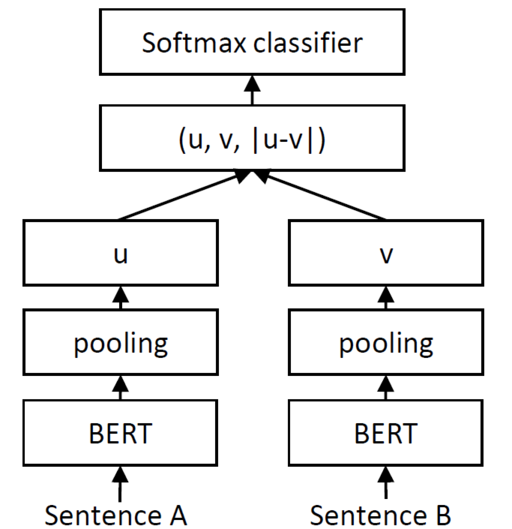

**Download NLI dataset**

In [ ]:
!wget 'https://sbert.net/datasets/AllNLI.tsv.gz'

In [12]:
data = pd.read_csv('AllNLI.tsv.gz', nrows=9, compression='gzip', delimiter='\t')
data.head()

,split,dataset,filename,sentence1,sentence2,label
0,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,train,SNLI,snli_1.0_train,Children smiling and waving at camera,They are smiling at their parents,neutral
4,train,SNLI,snli_1.0_train,Children smiling and waving at camera,There are children present,entailment


**Reading NLI data, preparing a training loop and constructing a model (BertClassifier) that uses the above method**

In [13]:
def load_nli_dataset(file_name):
    nli_samples = {'train': []}

    with gzip.open(file_name, 'rt', encoding='utf-8') as csv_file:
        lines = csv_file.readlines()

        for line in lines:
            parts = line.strip().split('\t')

            if len(parts) >= 4:
                split = parts[0]
                sentence1 = parts[3]
                sentence2 = parts[4]
                label = parts[5]

                if split == 'train':
                    nli_samples[split].append((sentence1, sentence2, label))

    return nli_samples

def train_loop(model, optimizer, dataloader, num_epochs, device):
    model.to(device)
    model.train()
    eval_interval = 10

    # Loop through the specified number of epochs
    for epoch in range(num_epochs):
        total_loss = 0.0
        total_interval_loss = 0.0
        num_batches = len(dataloader)

        # Iterate through the batches in the dataloader
        for batch_idx, batch in enumerate(dataloader):
            # Calculate the loss using the model
            loss = model(batch)
            total_interval_loss += loss.item()

            # Zero the gradients, perform backpropagation, and update the model's parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print the average loss at specified evaluation intervals
            if (batch_idx + 1) % eval_interval == 0:
                avg_loss = total_interval_loss / eval_interval
                print(f'Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx + 1}/{num_batches}, Average Loss: {avg_loss:.4f}')
                total_loss += total_interval_loss
                total_interval_loss = 0.0

        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}')


class BertClassifier(nn.Module):
    def __init__(self, model, num_labels):
        super(BertClassifier, self).__init__()
        self.num_labels = num_labels
        self.bert = model
        self.classifier = nn.Linear(self.bert.config.hidden_size * num_labels, num_labels)

    def forward(self, batch):
        input_ids_premise = batch['input_ids1'].to(device)
        attention_mask_premise = batch['attention_mask1'].to(device)
        input_ids_hypothesis = batch['input_ids2'].to(device)
        attention_mask_hypothesis = batch['attention_mask2'].to(device)

        labels = batch['labels']
        labels_dict = {'entailment': 0,  'contradiction': 1, 'neutral': 2}

        # Convert NLI labels to numerical format
        for i in range(len(labels)):
            labels[i] = labels_dict[labels[i]]
        labels = torch.tensor(labels).to(device)

        # Get BERT embeddings for premise and hypothesis sentences
        outputs_premise = self.bert(input_ids=input_ids_premise, attention_mask=attention_mask_premise)
        outputs_hypothesis = self.bert(input_ids=input_ids_hypothesis, attention_mask=attention_mask_hypothesis)

        u = outputs_premise[1]
        v = outputs_hypothesis[1]
        abs_diff = torch.abs(u - v)

        # Concatenate BERT representations (u, v, |u-v|)
        combined_rep = torch.cat((u, v, abs_diff), dim=1)

        # Apply linear classifier and softmax to obtain probabilities
        logits = self.classifier(combined_rep)
        probabilities = F.softmax(logits, dim=1)

        # Calculate cross-entropy loss
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(probabilities, labels)

        return loss

**Training**

In [ ]:
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
num_labels = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

nli_dataset = load_nli_dataset('AllNLI.tsv.gz')
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True)

bert = Bert(bert_config).load_model('bert_tiny.bin')
# bert = AutoModel.from_pretrained(MODEL_NAME)
bert_classifier = BertClassifier(bert, num_labels)

# Creating optimizer and running training loop
optimizer = AdamW(bert_classifier.parameters(), lr=5e-5)
train_loop(bert_classifier, optimizer, train_dataloader, num_epochs, device)

**Evaluation**

In [15]:
result_from_classification = eval_loop(bert, test_dataloader, device)
print(f'Pearson correlation: {result_from_classification[0]:.2f}\nSpearman correlation: {result_from_classification[1]:.2f}')

Pearson correlation: 0.41
Spearman correlation: 0.43


### **Leveraging a contrastive approach using NLI dataset and constructing BertContrastive**

In [16]:
# Creates triplets with all possible combinations of (anchor, positive, negative)
def load_contrastive_nli_dataset(file_name):
    triplets = {'train': []}
    current_anchor = None
    positive_sentences = []  # Store positive (entailment) sentences
    negative_sentences = []  # Store negative (contradiction or neutral) sentences

    with gzip.open(file_name, 'rt', encoding='utf-8') as csv_file:
        lines = csv_file.readlines()

        i = 0

        while i < len(lines):
            parts = lines[i].strip().split('\t')

            if len(parts) >= 4:
                split = parts[0]
                sentence1 = parts[3]
                label = parts[5]

                if split == 'train':
                    # Save the current_anchor
                    if current_anchor is None:
                        current_anchor = sentence1
                        continue

                    if sentence1 == current_anchor:
                        if label == 'entailment':
                            positive_sentences.append(parts[4])  # Add positive sentences
                        elif label == 'contradiction' or label == 'neutral':
                            negative_sentences.append(parts[4])  # Add negative sentences

                        i += 1

                    # Reset for the next unique sentence1
                    if current_anchor != sentence1:
                        # Create triplets for all combinations of positive and negative sentences for the current_anchor
                        for pos_sentence in positive_sentences:
                            for neg_sentence in negative_sentences:
                                triplets['train'].append((current_anchor, pos_sentence, neg_sentence))  # Add triplets
                        # Reset values for new anchor
                        current_anchor = None
                        positive_sentences = []
                        negative_sentences = []

                else:
                    i += 1

    return triplets

# Tokenize contrastive sentence pairs
def tokenize_contrastive_sentence_pair_dataset(dataset, tokenizer, max_length=512):
    tokenized_dataset = []

    # Loop through each item (sentence pair) in the dataset
    for item in dataset:
        sentence_anchor = item[0]
        sentence_positive = item[1]
        sentence_negative = item[2]

        # Check if either sentence is empty or None, and skip the current item if so
        if sentence_anchor is None or sentence_anchor.strip() == "" or sentence_positive is None or sentence_positive.strip() == "" or sentence_negative is None or sentence_negative.strip() == "":
            continue

        # Tokenize each sentence
        tokenized_item1 = tokenizer.encode_plus(sentence_anchor, "", max_length=max_length, padding='max_length', truncation=True, return_tensors='pt', return_attention_mask=True, return_token_type_ids=False, )
        tokenized_item2 = tokenizer.encode_plus(sentence_positive, "", max_length=max_length, padding='max_length', truncation=True, return_tensors='pt', return_attention_mask=True, return_token_type_ids=False, )
        tokenized_item3 = tokenizer.encode_plus(sentence_negative, "", max_length=max_length, padding='max_length', truncation=True, return_tensors='pt', return_attention_mask=True, return_token_type_ids=False, )

        # Append the tokenized item to the tokenized dataset list
        tokenized_dataset.append({
            'input_ids1': tokenized_item1['input_ids'][0],
            'attention_mask1': tokenized_item1['attention_mask'][0],
            'input_ids2': tokenized_item2['input_ids'][0],
            'attention_mask2': tokenized_item2['attention_mask'][0],
            'input_ids3': tokenized_item3['input_ids'][0],
            'attention_mask3': tokenized_item3['attention_mask'][0],
        })

    return tokenized_dataset

# Define the contrastive loss
class BertContrastive(nn.Module):
    def __init__(self, model, margin=0.5):
        super(BertContrastive, self).__init__()
        self.bert = model
        self.margin = margin

    def forward(self, batch):
        input_ids_anchor = batch['input_ids1'].to(device)
        attention_mask_anchor = batch['attention_mask1'].to(device)
        input_ids_positive = batch['input_ids2'].to(device)
        attention_mask_positive = batch['attention_mask2'].to(device)
        input_ids_negative = batch['input_ids3'].to(device)
        attention_mask_negative = batch['attention_mask3'].to(device)

        # Get embeddings for anchor, positive, and negative sentences from [CLS]
        embeddings_anchor = self.bert(input_ids=input_ids_anchor, attention_mask=attention_mask_anchor)[1]
        embeddings_positive = self.bert(input_ids=input_ids_positive, attention_mask=attention_mask_positive)[1]
        embeddings_negative = self.bert(input_ids=input_ids_negative, attention_mask=attention_mask_negative)[1]

        # Compute cosine similarity between embeddings of anchor and positive, and anchor and negative
        sim_pos = torch.cosine_similarity(embeddings_anchor, embeddings_positive, dim=1)
        sim_neg = torch.cosine_similarity(embeddings_anchor, embeddings_negative, dim=1)

        # Calculate the contrastive loss
        losses = self.contrastive_loss(sim_pos, sim_neg)

        # Average the losses over the batch
        loss = torch.mean(losses)

        return loss

    def contrastive_loss(self, sim_pos, sim_neg):
        loss = 0.5 * (1 - sim_pos)**2 + 0.5 * torch.clamp(sim_neg - self.margin, min=0)**2
        return loss

**Training**

In [ ]:
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
num_labels =3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

nli_dataset = load_contrastive_nli_dataset('AllNLI.tsv.gz')
tokenized_train = tokenize_contrastive_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128) # Edited function
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size)

bert = Bert(bert_config).load_model('bert_tiny.bin')
# bert = AutoModel.from_pretrained(MODEL_NAME)
bert_contrastive = BertContrastive(bert)

# Creating optimizer and running training loop
optimizer = AdamW(bert_contrastive.parameters(), lr=5e-5)
train_loop(bert_contrastive, optimizer, train_dataloader, num_epochs, device)

**Evaluation**

In [18]:
result_from_contrastive = eval_loop(bert, test_dataloader, device)
print(f'Pearson correlation: {result_from_contrastive[0]:.2f}\nSpearman correlation: {result_from_contrastive[1]:.2f}')

Pearson correlation: 0.49
Spearman correlation: 0.48


### **Comparing the result of pretrained BERT, BertClassifier and BertContrastive**

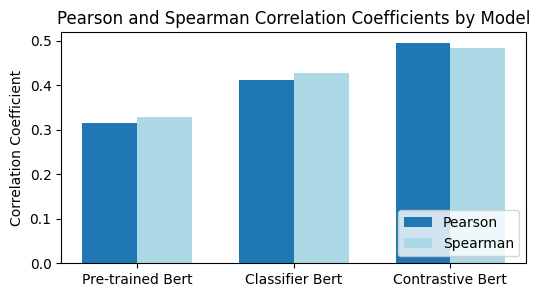

In [19]:
import matplotlib.pyplot as plt

model_names = ['Pre-trained Bert', 'Classifier Bert', 'Contrastive Bert']
cosine_similarities = [model_results[i]['similarity_scores'] for i in range(3)]
labels = [model_results[i]['all_labels'] for i in range(3)]

# Calculate Pearson and Spearman correlation coefficients for each model
pearson_correlations = [pearsonr(cosine_similarities[i], labels[i])[0] for i in range(3)]
spearman_correlations = [spearmanr(cosine_similarities[i], labels[i])[0] for i in range(3)]

# Create a DataFrame to store correlation data
correlation_data = pd.DataFrame({
    'Model Name': model_names,
    'Pearson Correlation': pearson_correlations,
    'Spearman Correlation': spearman_correlations
})

bar_width = 0.35
index = np.arange(len(model_names))

# Create a bar plot to visualize correlation coefficients
plt.figure(figsize=(6, 3))
plt.bar(index, correlation_data['Pearson Correlation'], bar_width, label='Pearson')
plt.bar(index + bar_width, correlation_data['Spearman Correlation'], bar_width, label='Spearman', color='lightblue')

plt.ylabel('Correlation Coefficient')
plt.title('Pearson and Spearman Correlation Coefficients by Model')
plt.xticks(index + bar_width / 2, model_names)
plt.legend(loc='lower right')

plt.show()

As is visible, the bert model trained via the contrastive approach has learnt sentence embeddings that are better than that learned by the model trained on classification, which itself does better than the pre-trained bert.

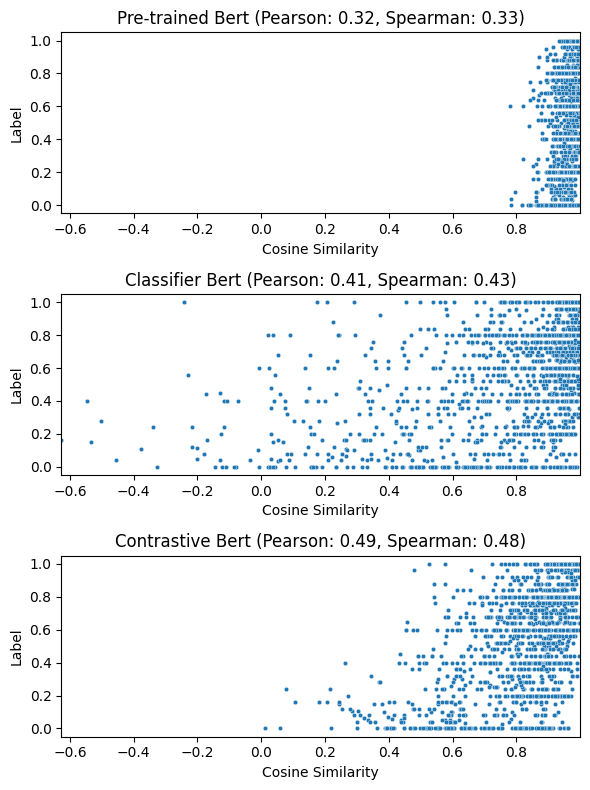

In [20]:
import seaborn as sns

model_names = ['Pre-trained Bert', 'Classifier Bert', 'Contrastive Bert']

# Extract cosine similarities and labels for each model's results
cosine_similarities_set1 = model_results[0]['similarity_scores']
labels_set1 = [label / 5 for label in model_results[0]['all_labels']]
cosine_similarities_set2 = model_results[1]['similarity_scores']
labels_set2 = [label / 5 for label in model_results[1]['all_labels']]
cosine_similarities_set3 = model_results[2]['similarity_scores']
labels_set3 = [label / 5 for label in model_results[2]['all_labels']]

# Create data dictionaries for each model's results
data_set1 = {'Cosine Similarity': cosine_similarities_set1, 'Label': labels_set1}
data_set2 = {'Cosine Similarity': cosine_similarities_set2, 'Label': labels_set2}
data_set3 = {'Cosine Similarity': cosine_similarities_set3, 'Label': labels_set3}

# Create DataFrames from the data dictionaries
df_set1 = pd.DataFrame(data_set1)
df_set2 = pd.DataFrame(data_set2)
df_set3 = pd.DataFrame(data_set3)

# Create horizontal subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 8))

# Define the same x-axis range for all subplots
x_axis_range = (min(min(cosine_similarities_set1), min(cosine_similarities_set2), min(cosine_similarities_set3)),
                max(max(cosine_similarities_set1), max(cosine_similarities_set2), max(cosine_similarities_set3)))

# Create scatterplots for each model's results

sns.scatterplot(x='Cosine Similarity', y='Label', data=df_set1, ax=axs[0], s=10)
axs[0].set_xlim(x_axis_range)
axs[0].set_title(f'{model_names[0]} (Pearson: {pearson_correlations[0]:.2f}, Spearman: {spearman_correlations[0]:.2f})')

sns.scatterplot(x='Cosine Similarity', y='Label', data=df_set2, ax=axs[1], s=10)
axs[1].set_xlim(x_axis_range)
axs[1].set_title(f'{model_names[1]} (Pearson: {pearson_correlations[1]:.2f}, Spearman: {spearman_correlations[1]:.2f})')

sns.scatterplot(x='Cosine Similarity', y='Label', data=df_set3, ax=axs[2], s=10)
axs[2].set_xlim(x_axis_range)
axs[2].set_title(f'{model_names[2]} (Pearson: {pearson_correlations[2]:.2f}, Spearman: {spearman_correlations[2]:.2f})')

plt.tight_layout()
plt.show()